# Connection algorithm unknown

In this toy example, we analyze connectivity that has been generated by an unknown algorithm.
The algorithm is very simple and can be implemented in under 15 lines of code.

But at this point, we know nothing about its nature.

We will load the instances and analyze them and see what we can find out about them.

## Loading the data
Below, we load the connectivity instances from an hdf5 archive.
We try to load the hdf5 file from a shared Google Drive. If that fails, obtain the hdf5 archive from [this link](https://openbraininstitute-my.sharepoint.com/:u:/g/personal/michael_reimann_openbraininstitute_org/EZS2SyzBuDxLvNON_Zv6EckBiaycC68qhVRWahB-Ia3gJg?e=MJMkuZ)

In [ ]:
!pip install numpy
!pip install pandas
!pip install Connectome-Utilities
!pip install connectome-analysis
!pip install scipy

In [ ]:
use_gdrive = True

if use_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

    # Assumes a shortcut to the shared drive has been placed in your Drive.
    file_path_in_gdrive = "/content/drive/MyDrive/NSC6085_Student_Share/April08/data/microns_mm3_connectome_v1181.h5"
    microns_data = conntility.ConnectivityMatrix.from_h5(file_path_in_gdrive, 'condensed')
else:
    # Alternatively, if the GDrive method does not work, you can download the file separately and place it into the local file system.
    # Obtain from: https://doi.org/10.5281/zenodo.13849415
    microns_data = conntility.ConnectivityMatrix.from_h5("./microns_mm3_connectome_v1181.h5", 'condensed')


In [ ]:
import numpy
import pandas
import conntility
import connalysis
from scipy import sparse

use_gdrive = True

if use_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

    # Assumes a shortcut to the shared drive has been placed in your Drive.
    fn_data = "/content/drive/MyDrive/NSC6085_Student_Share/April08/data/unknown_algorithm_con_mat_samples.h5"
else:
    # Alternatively, if the GDrive method does not work, you can download the file separately and place it into the local file system.
    # Obtain from the link listed above.
    fn_data = "./unknown_algorithm_con_mat_samples.h5"

samples = conntility.ConnectivityGroup.from_h5(fn_data)

print("Loaded {0} sample connectivity matrices.".format(len(samples.index)))

Loaded 10 sample connectivity matrices.


## Accessing the data

In the following cells we illustrate ways to access the loaded data and analyze it

In [6]:
# The loaded data represents several samples of connectivity. Individual instances can be accessed by indexing.
# In this example, the index is a range counting the instances from 0 to 10.
display(samples.index)

# First instance
instance = samples[0]

MultiIndex([(0,),
            (1,),
            (2,),
            (3,),
            (4,),
            (5,),
            (6,),
            (7,),
            (8,),
            (9,)],
           names=['sample_id'])

In [9]:
# Each instance represents a connectivity graph.
# The adjacency matrix of the graph can be accessed in a sparse or dense representation.
display(instance.matrix)  # scipy.sparse matrix representation
display(instance.array)  # dense representation as numpy.array

# Properties are associated with the nodes (i.e., the neurons). 
# In this example, the only properties are the locations of the neurons in an abstract 2d coordinate system.
display(instance.vertices.head())  # pandas.Dataframe, each row a neuron

<5000x5000 sparse matrix of type '<class 'numpy.bool_'>'
	with 1108289 stored elements in COOrdinate format>

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

,index,x,y
0,0,262.905562,246.579087
1,1,360.425498,23.870457
2,2,253.357691,206.812600
3,3,281.206861,292.797977
4,4,223.141475,54.694971


## Simple analysis
Here, we perform a very simple analysis. 

For reasons that will become obvious later, we implement the analysis in a function that takes the following two arguments: First, the sparse representation of the adjacency (instance.matrix), second, the Dataframe of node properties (instance.vertices).

In [11]:
def mean_connection_probability(m, v):
    n_connections = m.nnz  # number of nonzero elements, i.e., connected pairs
    n_pairs = len(v) * (len(v) - 1)  # number of potential connections. Minus one because we assume no autapses.
    return n_connections / n_pairs

print(mean_connection_probability(instance.matrix, instance.vertices))

0.044340428085617126


To quickly apply analyses to all instances, we wrap the specification of the analysis into a dictionary. Then we use the .analyze function.

In [12]:
analysis = {
    "analyses": {
        "mean_connection_probability": {
            "source": mean_connection_probability,
            "output": "Value"
        }
    }
}
display(samples.analyze(analysis))

{'mean_connection_probability': sample_id
 0            0.044340
 1            0.044588
 2            0.044888
 3            0.044465
 4            0.045021
 5            0.044880
 6            0.044539
 7            0.044390
 8            0.044745
 9            0.044585
 dtype: float64}

## A look at the adjacency matrix 

A quick peak often helps to understand what we are dealing with.

Select from the dropdown the instance to visualize.

In [23]:
from matplotlib import pyplot as plt
from ipywidgets import widgets

select_instance = widgets.Dropdown(options=samples.index.values)

def plot_fcn(idx):
    instance = samples[idx]
    ax = plt.figure(figsize=(4, 4)).gca()
    ax.imshow(instance.array, interpolation="nearest",
              cmap="Greys_r")
    ax.set_xlabel("Node id"); ax.set_ylabel("Node id")

ia = widgets.interactive(plot_fcn, idx=select_instance)
display(ia)

interactive(children=(Dropdown(description='idx', options=((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,…

The following visualizes the spatial locations of innervated neurons.
Pick an instance using the dropdown and a node id using the slider.

In red, the location of the picked neuron is indicated, in blue the locations of neurons innervated by it.

In [ ]:
from matplotlib import pyplot as plt
from ipywidgets import widgets

select_nrn = widgets.IntSlider(0, min=0, max=len(instance))
select_instance = widgets.Dropdown(options=samples.index.values)

def plot_fcn(idx, n):
    instance = samples[idx]
    m = instance.matrix.tocsr()
    coords = instance.vertices[["x", "y"]].values
    ax = plt.figure(figsize=(4, 4)).gca()
    ax.scatter(coords[m[n].indices, 0], coords[m[n].indices, 1])
    ax.plot(coords[n, 0], coords[n, 1], marker='h', color="red")
    plt.axis("equal")

ia = widgets.interactive(plot_fcn, idx=select_instance, n=select_nrn)
display(ia)

interactive(children=(Dropdown(description='idx', options=((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,…

While the raw visualization of the matrices is not helpful, in the visualization of the locations of efferents, we can see what appears to be spatially clustered connectivity.

Let's see if we can find the clusters. For that, we use the established Louvain algorithm.

We concatenate the outgoing and incoming connectivity and cluster the cosine similarity of the results.

In [ ]:
def clusters_from_conmat(m, v):
    # Concatenate incoming and outgoing connectivity
    CC = numpy.hstack([m.todense(), m.transpose().todense()]).astype(float)
    # Make it sparse. This will speed up the later multiplication
    CC_sp = sparse.csc_matrix(CC)

    # Normalization by the product of their lengths.
    Nrml = numpy.linalg.norm(CC, axis=1)
    Nrml = Nrml.reshape((-1, 1)) * Nrml.reshape((1, -1))

    # Dot product, followed by normalization. Back into dense representation
    S = CC_sp * CC_sp.transpose()
    S = numpy.array(S.todense()) / Nrml

    # Call Louvain clustering method
    from sknetwork.clustering import Louvain
    louvain = Louvain(1.0)
    cluster_ids = louvain.fit_predict(S)
    # The output is a list of integers. One entry per node. It indicates the identity of the cluster of the node.
    return pandas.Series(cluster_ids, index=v.index)

# As an example, we run clustering of an exemplary instance and display the number of clusters and their members
example_clusters = clusters_from_conmat(instance.matrix, instance.vertices)
display(example_clusters.value_counts())

0    1057
1    1050
2    1018
3     950
4     925
Name: count, dtype: int64

In [ ]:
analysis = {
    "analyses": {
        "clusters": {
            "source": clusters_from_conmat,
            "output": "Series"
        }
    }
}
res = samples.analyze(analysis)

# We add the resulting cluster ids as properties associated with the vertices of each sample
for smpl_id in samples.index:
    samples[smpl_id].add_vertex_property("cluster_id", res["clusters"][smpl_id].values)

# This is how they can be accessed. Should be the same as in the previous cell.
samples[0].vertices["cluster_id"].value_counts()

cluster_id
0    1057
1    1050
2    1018
3     950
4     925
Name: count, dtype: int64

In [53]:
from matplotlib import pyplot as plt
from ipywidgets import widgets

select_instance = widgets.Dropdown(options=samples.index.values)

def plot_fcn(idx):
    instance = samples[idx]
    ax = plt.figure(figsize=(4, 4)).gca()
    instance.vertices.groupby("cluster_id").apply(lambda _x: ax.scatter(_x["x"], _x["y"]))
    plt.axis("equal")

ia = widgets.interactive(plot_fcn, idx=select_instance)
display(ia)

interactive(children=(Dropdown(description='idx', options=((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,…

We see the same spatial structure of clusters for all instances. 

Note that the actual cluster id associated with each location is different between instances (and hence the colors of the plots), but that means nothing, as cluster ids are arbitrary.

Now, lets see if these clusters help us decipher the connectivity matrices. To that end, we visualize the adjacency matrices again, but sorted according to the cluster ids, i.e., neurons belonging to the same cluster are plotted together.

In [ ]:
from matplotlib import pyplot as plt
from ipywidgets import widgets

select_instance = widgets.Dropdown(options=samples.index.values)

def plot_fcn(idx):
    instance = samples[idx]
    # Adjaceny matrix, sorted by cluster id.
    _srt = numpy.argsort(instance.vertices["cluster_id"])
    arr = instance.array[numpy.ix_(_srt, _srt)]

    # Matrix of connection probabilities between clusters
    vc = instance.vertices["cluster_id"].value_counts()
    nrmlz = vc.values.reshape((-1, 1)) * vc.values.reshape((1, -1))
    P = instance.condense("cluster_id").array / nrmlz
    
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(1, 2, 1); ax2 = fig.add_subplot(1, 2, 2)
    ax1.imshow(arr, interpolation="nearest",
              cmap="Greys_r")
    ax1.set_xlabel("Node id"); ax1.set_ylabel("Node id")
    plt.colorbar(ax2.imshow(P))
    ax2.set_xlabel("Cluster id"); ax2.set_ylabel("Cluster id")

ia = widgets.interactive(plot_fcn, idx=select_instance)
display(ia)

interactive(children=(Dropdown(description='idx', options=((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,…

## Generating connectivity mimicking the samples
We see that there is a clear structure of connectivity between the clusters. Note again, that the order of the clusters is arbitray, so that they show in a different permutation in the plot on the right means nothing.

Let's try and build connectivity based on this clear principle.

For that, we use the cluster-to-cluster connection probability matrices shown above. We expand it to a neuron-to-neuron connection probability matrix. That is, for each pair of neurons, we look up their connection probability based on the clusters they are assigned to. Then we build a random instance based on the probabilities. 
Here, we build one instance per sample, but we really could build any number of them.

We keep the original cluster assignments, but rename them from "cluster_id" to "original_cluster_id" for later comparison.

In [89]:
def make_node_to_node_con_prob(instance):
    vc = instance.vertices["cluster_id"].value_counts()
    n_pairs = vc.values.reshape((-1, 1)) * vc.values.reshape((1, -1))
    instance_cond = instance.condense("cluster_id")
    P_node = numpy.zeros((len(instance), len(instance)))
    for _, row1 in instance_cond.vertices.iterrows():
        for _, row2 in instance_cond.vertices.iterrows():
            number_connections = instance_cond.array[row1["index"], row2["index"]]
            p_c_to_c = number_connections / n_pairs[row1["index"], row2["index"]]
            P_node[numpy.ix_(row1["_idxx_in_original"], row2["_idxx_in_original"])] = p_c_to_c
    numpy.fill_diagonal(P_node, 0.0)
    return P_node


def make_fitted_instance(instance):
    P = make_node_to_node_con_prob(instance)
    M = numpy.random.rand(*P.shape) < P
    vp = instance._vertex_properties.rename(columns={"cluster_id": "original_cluster_id"})
    M_fit = conntility.ConnectivityMatrix(M, vertex_properties=vp)
    return M_fit


fitted_list = [
    make_fitted_instance(samples[_idx])
    for _idx in samples.index
]
fitted = conntility.ConnectivityGroup(samples.index.to_frame(), fitted_list)

As a sanity check, let's also build the clusters for the fitted instances and visualize them.

We also compare the cluster ids from the fitted connectivity to the original ids.

In [90]:
analysis = {
    "analyses": {
        "clusters": {
            "source": clusters_from_conmat,
            "output": "Series"
        }
    }
}
res = fitted.analyze(analysis)

# We add the resulting cluster ids as properties associated with the vertices of each sample
for smpl_id in fitted.index:
    fitted[smpl_id].add_vertex_property("cluster_id", res["clusters"][smpl_id].values)


select_instance = widgets.Dropdown(options=fitted.index.values)

def plot_fcn(idx):
    instance = fitted[idx]
    # Adjaceny matrix, sorted by cluster id.
    _srt = numpy.argsort(instance.vertices["cluster_id"])
    arr = instance.array[numpy.ix_(_srt, _srt)]

    # Matrix of connection probabilities between clusters
    vc = instance.vertices["cluster_id"].value_counts()
    nrmlz = vc.values.reshape((-1, 1)) * vc.values.reshape((1, -1))
    P = instance.condense("cluster_id").array / nrmlz
    
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(1, 2, 1); ax2 = fig.add_subplot(1, 2, 2)
    ax1.imshow(arr, interpolation="nearest",
              cmap="Greys_r")
    ax1.set_xlabel("Node id"); ax1.set_ylabel("Node id")
    plt.colorbar(ax2.imshow(P))
    ax2.set_xlabel("Cluster id"); ax2.set_ylabel("Cluster id")

ia = widgets.interactive(plot_fcn, idx=select_instance)
display(ia)

interactive(children=(Dropdown(description='idx', options=((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,…

In [109]:
select_instance = widgets.Dropdown(options=fitted.index.values)

def plot_fcn(idx):
    instance = fitted[idx]
    vc = instance.vertices[["cluster_id", "original_cluster_id"]].value_counts()
    vc = vc.unstack("original_cluster_id", fill_value=0)
    
    ax = plt.figure(figsize=(4, 4)).gca()
    plt.colorbar(ax.imshow(vc.values), label="Number of neurons")
    ax.set_xlabel("original cluster id"); ax.set_ylabel("fitted cluster id")

ia = widgets.interactive(plot_fcn, idx=select_instance)
display(ia)

interactive(children=(Dropdown(description='idx', options=((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,…

We see a clear correspondence between original and fitted clusters. 

Does that mean we have figured out the structure / algorithm of the original connectivity matrix?

Let's perform some additional analyses of the structure of the samples and the fitted instances.

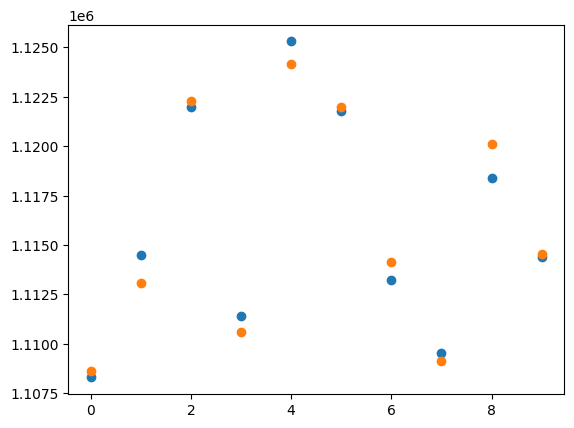

In [104]:
def connection_count(m, v):
    return m.nnz

analysis = {
    "analyses": {
        "n_connections": {
            "source": connection_count,
            "output": "Value"
        }
    }
}

res_smpl = samples.analyze(analysis)
res_fit = fitted.analyze(analysis)

plt.plot(res_smpl["n_connections"].values, 'o')
plt.plot(res_fit["n_connections"].values, 'o')

Unsurprisingly, the number of connections matches closely.

Add your own analysis, if you want

In [ ]:
def custom_analysis(m, v):
    # Fill me in!
    pass

analysis = {
    "analyses": {
        "custom": {
            "source": custom_analysis,
            "output": "Value"
        }
    }
}

res_smpl = samples.analyze(analysis)
res_fit = fitted.analyze(analysis)

plt.plot(res_smpl["custom"].values, 'o')
plt.plot(res_fit["custom"].values, 'o')

However, there are analyses, where we can find significant differences!

In this example, we calculate the overexpression of reciprocal (or bidirectional) connections.
That is, how much is the number of reciprocal connections different from the number expected in a non-structured (Erdos-Renyi) network?

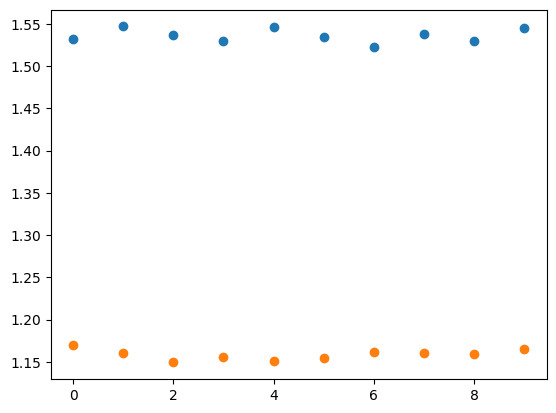

In [105]:
def remove_non_reciprocal(m):
    """
    Returns a copy of a sparse.coo_matrix with all connections that are not reciprocal removed.
    """
    e_idxx = pandas.DataFrame({
        "row": numpy.hstack([m.row, m.col]),
        "col": numpy.hstack([m.col, m.row])
    }, index=numpy.hstack([range(m.nnz), range(m.nnz)]))
    vc = e_idxx.drop_duplicates(keep="last").index.value_counts()
    idxx = vc.index[vc == 1].values
    a, b = m.row[idxx], m.col[idxx]

    r = sparse.coo_matrix((m.data[idxx], (a, b)), shape=m.shape)
    return r

def reciprocal_overexpression(adj, node_properties):
    """
    Calculates the ratio of the observed to the expected reciprocal connection probability.
    """
    adj = adj.tocoo()
    n_pairs = adj.shape[0] * (adj.shape[1] - 1)  # Number of potential connections. No potential connections along main diagonal.
    base_con_prob = adj.nnz / n_pairs  # .nnz is the number of observed connections in the matrix. Divide by pairs to get connection probability
    rec_con_prob = remove_non_reciprocal(adj).nnz / n_pairs  # Same, but for the matrix with non-reciprocal connections removed.
    return rec_con_prob / (base_con_prob ** 2)


analysis = {
    "analyses": {
        "reciprocal_over": {
            "source": reciprocal_overexpression,
            "output": "Value"
        }
    }
}

res_smpl = samples.analyze(analysis)
res_fit = fitted.analyze(analysis)

plt.plot(res_smpl["reciprocal_over"].values, 'o')
plt.plot(res_fit["reciprocal_over"].values, 'o')

Another one is the common neighbor bias. 

This describes a connectivity bias that is often found in biological neuronal networks: Connections are more abundant between pairs of neurons that have many common neighbors. A common neighbor is a third neuron that is connected to both neurons of the pair.

We use the "common_neighbor_connectivity_bias" function in the connalysis package. It returns (among other outputs) the increase in expected common neighbor count for connected pairs over unconnected pairs, normalized by the overall mean common neighbor count. 

If you are motivated, you can try to write your own implementation of this, based on the description above.

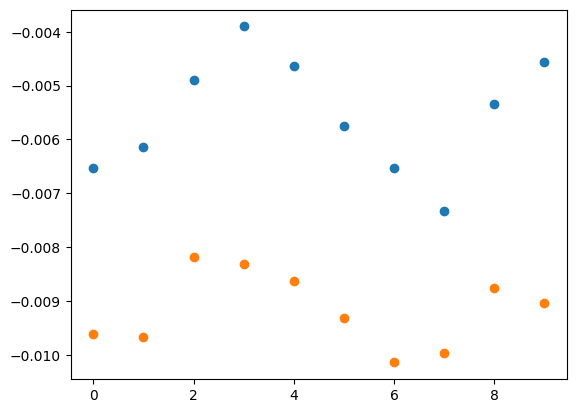

In [106]:
import connalysis


analysis = {
    "analyses": {
        "cn_bias": {
            "source": lambda *args: connalysis.network.classic.common_neighbor_connectivity_bias(*args)[1],
            "output": "Value"
        }
    }
}

res_smpl = samples.analyze(analysis)
res_fit = fitted.analyze(analysis)

plt.plot(res_smpl["cn_bias"].values, 'o')
plt.plot(res_fit["cn_bias"].values, 'o')

From the negative values we see that both types of connectivity have a slight _decrease_ in connectivity with increasing common neighbors. But we also see significant differences between the original samples and the fitted ones.

## Fixing the fitted instances
If you are motivated, you can use the next cells for the following exercise:

Build fitted instances that do not only match the connection probabilities between detected cluster (as above), but also separately the reciprocal connection probabilities between them. That is, build the matrix of reciprocal connection probabilities between all pairs of clusters, then construct a random instance based on overall and reciprocal connection probabilities. 
Then ensure that the total number of connections still matches and see if this "fixes" the differences in common neighbor bias.

In [107]:
# Build "fixed" fitted instances here and test them.
# This is optional.

In [119]:
from sklearn.decomposition import PCA


def pca_of_connectivity_by_location(m, v):
    m = numpy.array(m.todense())

    # As before, concatenate incoming and outgoing connectivity
    CC = numpy.hstack([m, m.transpose()]).astype(float)

    # Dimensionality reduction of connectivity. Here, we use simple PCA. But really any method would work
    pca = PCA(2).fit_transform(CC)

    # We want to understand the spatial structure of the pca values.
    # So we bind the x and y coordinates of the neurons, then calculate the mean values of the first and
    # second PCA component for each bin.
    xbins = numpy.linspace(0, 400, 25)
    ybins = xbins.copy()
    xbin_idx = numpy.digitize(v["x"], xbins) - 1
    ybin_idx = numpy.digitize(v["y"], ybins) - 1

    df = pandas.DataFrame({
        "xbin_id": xbin_idx,
        "ybin_id": ybin_idx,
        "comp1": pca[:, 0],
        "comp2": pca[:, 1]
    })
    # Return mean values per bin
    return df.groupby(["xbin_id", "ybin_id"])[["comp1", "comp2"]].mean()


analysis = {
    "analyses": {
        "pca_spatial": {
            "source": pca_of_connectivity_by_location,
            "output": "Frame"
        }
    }
}

res_smpl = samples.analyze(analysis)
res_fit = fitted.analyze(analysis)


In [127]:
select_instance = widgets.Dropdown(options=fitted.index.values)

def plot_fcn(idx):
    pca_df1 = res_smpl["pca_spatial"].loc[idx]
    pca_df2 = res_fit["pca_spatial"].loc[idx]

    fig = plt.figure(figsize=(8, 8))
    i = 1

    # Iterate over the two pca components, showing them separately
    for _comp in ["comp1", "comp2"]:
        ax1 = fig.add_subplot(2, 2, i); ax2 = fig.add_subplot(2, 2, i + 1)
        i += 2
        ax1.imshow(pca_df1[_comp].unstack("xbin_id"))
        if i == 5:
            ax1.set_xlabel("bin id"); ax2.set_xlabel("bin id")
        ax2.imshow(pca_df2[_comp].unstack("xbin_id"))
        ax1.set_ylabel("bin id"); ax2.set_ylabel("bin id")

        ax1.set_title("Original component {0}".format(int(i / 2)))
        ax2.set_title("Fitted component {0}".format(int(i / 2)))

ia = widgets.interactive(plot_fcn, idx=select_instance)
display(ia)

interactive(children=(Dropdown(description='idx', options=((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,…

## The solution

We see a hint of what might be the issue: The connectivity changes more gradually in the original connectivity, with no hard borders..? As if connectivity was dependent on location, but gradually so.

If you want, you can try to continue analyses to see if you can decipher the connectivity algorithm. And build improved fitted instances. Otherwise, the solution is below.

In [128]:
# Try to work here
# This is optional











# Spoiler block













## The algorithm

Below is the actual algorithm used to build the "samples".

It constructs connectivity as distance-dependent connectivity, however in a specific coordinate system:
The first coordinate is the distance of a neuron from a vertical line at x=190, the second coordinate is the distance of a neuron from a horizontal line at x=210.

This type of connectivity has been proposed as a model for inter-regional connectivity between neighboring brain regions. See Reimann et al., 2019 (Nat. Comms.) and Guyonnet-Hencke et al., 2023 (Netw. Neurosci.). The vertical and horizontal lines in this abstraction stand in for borders between brain regions. 

## The message

What was I trying to convey with this example?
1. It is hard to build an algorithm that models a given type of connectivity. Such an algorithm is a model, and as the saying goes: A model can never be proven right, only be proven wrong. Or another saying: All models are wrong, some are just useful.
2. That being said, when formulating algorithms it very easy to go the wrong way, based on seemingly obvious results. The apparent clusters in the data looked convincing with clearly structured connectivity between them. But objectively, they do not exist. Every neuron was connected according to the same rule. The only hard borders in the data were the "region borders", i.e., the horizontal and vertical lines to which distance was measured. And the detected cluster borders did in no way align with them.
3. Additionally, the "fitted" connectomes differed from the original instances in functionally relevant measures. It is always important to test the functionally relevant measures, such as reciprocity, clustering and motif counts.



In [ ]:
N = 5000
sz = 400
splt_x = 190
splt_y = 210

def make_dd_instance(N, sz, splt_x, splt_y):
    coords = numpy.random.rand(N, 2) * sz
    
    splt = numpy.array([[splt_x, splt_y]])
    D1 = numpy.abs(coords - splt).reshape((-1, 1, 2)) - numpy.abs(coords - splt).reshape((1, -1, 2))
    D1 = numpy.sqrt((D1 ** 2).sum(axis=2))
    D2 = numpy.abs(coords).reshape((-1, 1, 2)) - numpy.abs(coords).reshape((1, -1, 2))
    D2 = numpy.sqrt((D2 ** 2).sum(axis=2))

    D = D1 + numpy.maximum(splt_x - D2, 0)

    P = 1. / (0.2 * D + 1.5)

    P = P.sum(axis=1).mean() * P / P.sum(axis=1, keepdims=True)

    instance = numpy.random.rand(*P.shape) < P
    numpy.fill_diagonal(instance, False)
    M = conntility.ConnectivityMatrix(instance, vertex_properties=pandas.DataFrame({
        "x": coords[:, 0],
        "y": coords[:, 1]
    }))
    return M
